# Imports

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import math
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.preprocessing import StandardScaler

import warnings 
warnings.filterwarnings('ignore')

sns.set()

# Read data

In [75]:
df = pd.read_csv('boston.csv')
df.shape

(506, 14)

# Reduce memory usage

In [76]:
def convert_col_to_proper_int(df_col):
    col_type = df_col.dtype
#     print('convert_col_to_proper_int column: ', df_col.name, 'type: ', col_type, 'c_min: ', c_min)
    if ((str(col_type)[:3] == 'int') | (str(col_type)[:4] == 'uint')): # | (str(col_type)[:5] == 'float')
        c_min = df_col.min()
        c_max = df_col.max()
        if c_min < 0:
#             print('c_min: ', c_min, 'less 0')
            if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                df_col = df_col.astype(np.int8)
            elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                df_col = df_col.astype(np.int16)
            elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                df_col = df_col.astype(np.int32)
            elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                df_col = df_col.astype(np.int64)
        else:
#             print('c_min: ', c_min, 'not less 0')
            if c_max <= np.iinfo(np.uint8).max:
                df_col = df_col.astype(np.uint8)
            elif c_max <= np.iinfo(np.uint16).max:
                df_col = df_col.astype(np.uint16)
            elif c_max <= np.iinfo(np.uint32).max:
                df_col = df_col.astype(np.uint32)
            elif c_max <= np.iinfo(np.uint64).max:
                df_col = df_col.astype(np.uint64)
            
    return df_col

def convert_col_to_proper_float(df_col):
    col_type = df_col.dtype
    if str(col_type)[:5] == 'float':
        unique_count = len(np.unique(df_col))
        df_col_temp = df_col.astype(np.float32)
        if len(np.unique(df_col_temp)) == unique_count:
            df_col = df_col_temp
            c_min = df_col.min()
            c_max = df_col.max()
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                df_col_temp = df_col.astype(np.float16)
                if len(np.unique(df_col_temp)) == unique_count:
                    df_col = df_col_temp
            
    return df_col

def float_to_int(df):
    """ iterate through all float columns of a dataframe and modify the data type
        to reduce memory usage.
    """
#     print('Begin float_to_int')
    for col in df.columns:
        col_type = df[col].dtype
#         print('column: ', col, 'type: ', col_type)
        if str(col_type)[:5] == 'float':
            if (df[col] % 1 == 0).all():
                df[col] = convert_col_to_proper_int(df[col].astype(np.int64))
    
    return df

def float_reduced(df):
    """ iterate through all float columns of a dataframe and modify the data type
        to reduce memory usage.
    """
#     print('Begin float_reduced')
    for col in df.columns:
        col_type = df[col].dtype
#         print('column: ', col, 'type: ', col_type)
        if str(col_type)[:5] == 'float':
            df[col] = convert_col_to_proper_float(df[col])
    
    return df

def int_reduced(df):
    """ iterate through all int columns of a dataframe and modify the data type
        to reduce memory usage.
    """
#     print('Begin float_reduced')
    for col in df.columns:
        df[col] = convert_col_to_proper_int(df[col])
    
    return df

def gentle_reduce_mem_usage(data, verbose = True):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage of dataframe: {:.2f} MB'.format(start_mem))

    for col in data.columns:
#         print(col, type(data[col]), data[col].shape)
        col_type = data[col].dtype

        if ((col_type != object) & (col_type != '<M8[ns]') & (col_type.name != 'category')):#
            c_min = data[col].min()
            c_max = data[col].max()
            if str(col_type)[:3] == 'int':
                data[col] = convert_col_to_proper_int(data[col])
            else:
                if (data[col] % 1 == 0).all():
                    data[col] = convert_col_to_proper_int(data[col].astype(np.int64))
                else:
                    data[col] = convert_col_to_proper_float(data[col])
        else: 
            try:
                data[col] = data[col].astype(np.float64)
                if (data[col] % 1 == 0).all():
                    data[col] = convert_col_to_proper_int(data[col].astype(np.int64))
                else:
                    data[col] = convert_col_to_proper_float(data[col])
            except:
                data[col] = data[col].astype('category')

    end_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage after optimization: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return data

# Columns info

In [77]:
df.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

There are 14 attributes in each case of the dataset. They are:

    CRIM - per capita crime rate by town
    ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
    INDUS - proportion of non-retail business acres per town.
    CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
    NOX - nitric oxides concentration (parts per 10 million)
    RM - average number of rooms per dwelling
    AGE - proportion of owner-occupied units built prior to 1940
    DIS - weighted distances to five Boston employment centres
    RAD - index of accessibility to radial highways
    TAX - full-value property-tax rate per 10,000 
    PTRATIO - pupil-teacher ratio by town
    B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
    LSTAT - % lower status of the population
    MEDV - Median value of owner-occupied homes in 1000's

In [78]:
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null int64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null int64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
MEDV       506 non-null float64
dtypes: float64(12), int64(2)
memory usage: 55.4 KB


In [79]:
feats = [f for f in df.columns if f not in ['MEDV']]
df[feats] = gentle_reduce_mem_usage(df[feats])

Memory usage of dataframe: 0.05 MB
Memory usage after optimization: 0.02 MB
Decreased by 67.2%


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float32
ZN         506 non-null float16
INDUS      506 non-null float16
CHAS       506 non-null uint8
NOX        506 non-null float16
RM         506 non-null float32
AGE        506 non-null float16
DIS        506 non-null float32
RAD        506 non-null uint8
TAX        506 non-null uint16
PTRATIO    506 non-null float16
B          506 non-null float32
LSTAT      506 non-null float32
MEDV       506 non-null float64
dtypes: float16(5), float32(5), float64(1), uint16(1), uint8(2)
memory usage: 20.8 KB


We have two features **uint8** we will check may be feature is categorical: 

In [81]:
df['RAD'].value_counts()

24    132
5     115
4     110
3      38
6      26
8      24
2      24
1      20
7      17
Name: RAD, dtype: int64

In [82]:
df['CHAS'].value_counts()

0    471
1     35
Name: CHAS, dtype: int64

Change data type to 'category':

In [83]:
df['RAD'] = df['RAD'].astype('category')
df['CHAS'] = df['CHAS'].astype('category')

In [84]:
# Info about columns
def feats_summary(df_):
    feats_to_exclude = [f for f in df_.columns if f in ['MEDV']]

    cat_cols  = [col for col in df_.columns if df_[col].dtype == 'object']
    cat_cols += [col for col in df_.columns if not pd.api.types.is_numeric_dtype(df_[col].dtype)]
    cat_cols  = list(set(cat_cols).difference(feats_to_exclude))

    num_cols = [col for col in df_.columns if pd.api.types.is_numeric_dtype(df_[col].dtype)]
    num_cols  = list(set(num_cols).difference(feats_to_exclude))
    print('''Columns summary (overall {}) : 
    1. Categorical: {}
    2. Numerical: {}
    3. Excluded: {}'''.format(len(df_.columns),len(cat_cols),len(num_cols),len(feats_to_exclude)))
    return feats_to_exclude,cat_cols,num_cols

In [85]:
_,cat_cols,num_cols = feats_summary(df)

Columns summary (overall 14) : 
    1. Categorical: 2
    2. Numerical: 11
    3. Excluded: 1


# Look into the data

In [86]:
df.head(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.310547,0,0.538086,6.575,65.18750,4.0900,1,296,15.296875,396.899994,4.98,24.0
1,0.02731,0.0,7.070312,0,0.468994,6.421,78.87500,4.9671,2,242,17.796875,396.899994,9.14,21.6
2,0.02729,0.0,7.070312,0,0.468994,7.185,61.09375,4.9671,2,242,17.796875,392.829987,4.03,34.7
3,0.03237,0.0,2.179688,0,0.458008,6.998,45.81250,6.0622,3,222,18.703125,394.630005,2.94,33.4
4,0.06905,0.0,2.179688,0,0.458008,7.147,54.18750,6.0622,3,222,18.703125,396.899994,5.33,36.2


In [87]:
df.tail(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
501,0.06263,0.0,11.929688,0,0.573242,6.593,69.1250,2.4786,1,273,21.0,391.989990,9.67,22.4
502,0.04527,0.0,11.929688,0,0.573242,6.120,76.6875,2.2875,1,273,21.0,396.899994,9.08,20.6
503,0.06076,0.0,11.929688,0,0.573242,6.976,91.0000,2.1675,1,273,21.0,396.899994,5.64,23.9
504,0.10959,0.0,11.929688,0,0.573242,6.794,89.3125,2.3889,1,273,21.0,393.450012,6.48,22.0
505,0.04741,0.0,11.929688,0,0.573242,6.030,80.8125,2.5050,1,273,21.0,396.899994,7.88,11.9


# Some statistic

In [88]:
df[num_cols].describe()

,RM,CRIM,INDUS,ZN,LSTAT,B,PTRATIO,TAX,NOX,DIS,AGE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,6.284634,3.613524,11.140625,11.367188,12.653064,356.674042,18.453125,408.237154,0.554688,3.795043,68.562500
std,0.702617,8.601545,6.859375,23.328125,7.141061,91.294861,2.166016,168.537116,0.115906,2.105710,28.156250
min,3.561000,0.006320,0.459961,0.000000,1.730000,0.320000,12.601562,187.000000,0.385010,1.129600,2.900391
25%,5.885500,0.082045,5.191406,0.000000,6.950000,375.377487,17.406250,279.000000,0.448975,2.100175,45.023438
50%,6.208500,0.256510,9.687500,0.000000,11.360000,391.440002,19.046875,330.000000,0.538086,3.207450,77.500000
75%,6.623500,3.677083,18.093750,12.500000,16.954999,396.225006,20.203125,666.000000,0.624023,5.188425,94.093750
max,8.780000,88.976196,27.734375,100.000000,37.970001,396.899994,22.000000,711.000000,0.871094,12.126500,100.000000


In [89]:
df.columns[df.isnull().any()] # No columns with NaN

Index([], dtype='object')

# Data visualisation

In [90]:
# helper function
def draw_plots(df,keys_to_draw:list,xlabel:str,ylabel:str,n_cols:int,graph_type:str):
    n_rows = math.ceil(len(keys_to_draw)/n_cols)
    for i in range(n_rows):
        _, ax = plt.subplots(nrows=1, 
                             ncols=n_cols, 
                             figsize=(16, 4))
        for j,col in enumerate(ax):  
            if (n_cols*i+j)<(len(keys_to_draw)):
                if graph_type == 'hist':
                    sns.distplot(df[keys_to_draw[n_cols*i+j]], ax=col)
                elif graph_type == 'boxplot':
                    sns.boxplot(x=df[keys_to_draw[n_cols*i+j]], ax=col)
                elif graph_type == 'countplot':
                    sns.countplot(x=keys_to_draw[n_cols*i+j], data=df,ax=col)
                col.set_title(keys_to_draw[n_cols*i+j])
                col.set_xlabel(xlabel)
                col.set_ylabel(ylabel)
        plt.show()

## Histograms

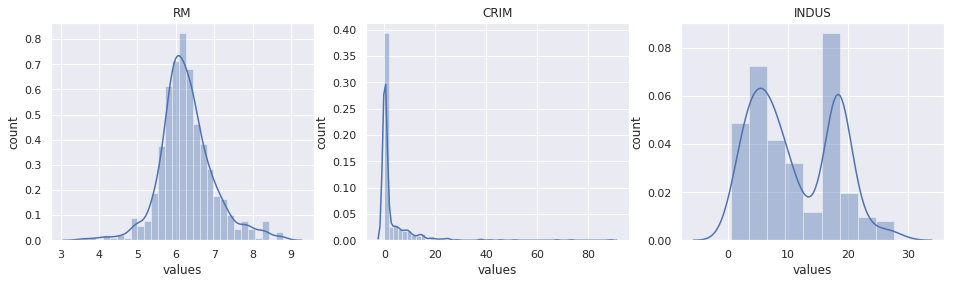

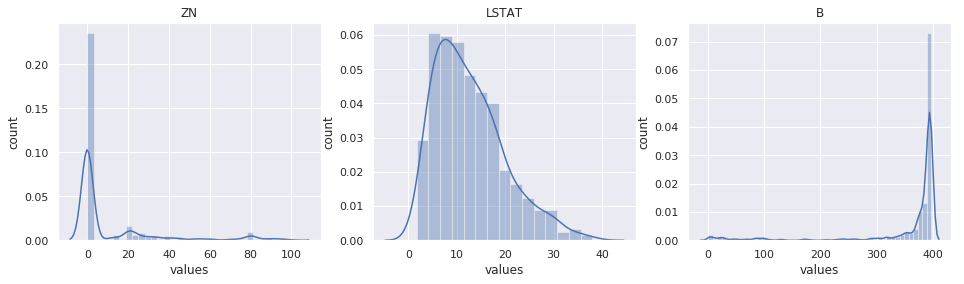

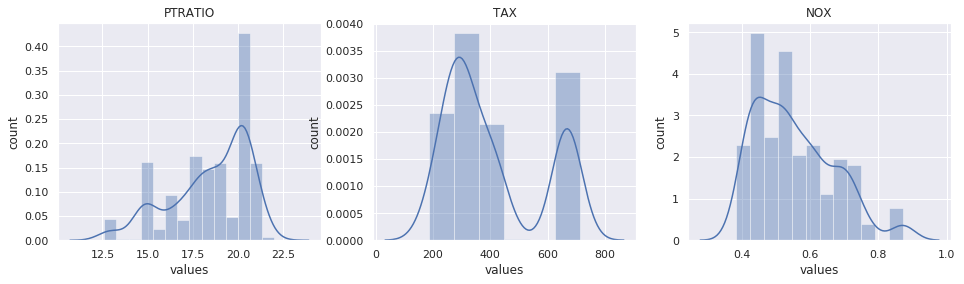

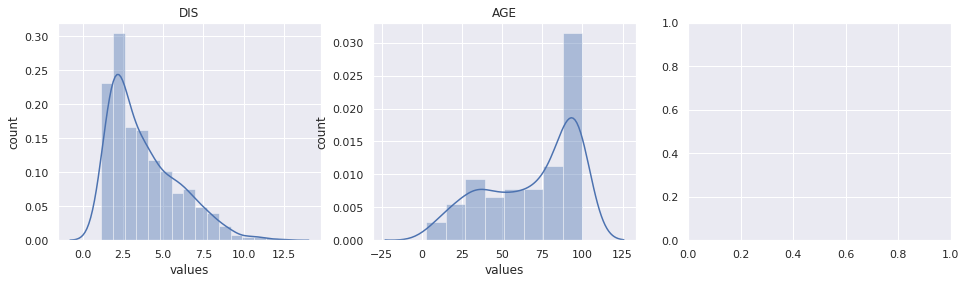

In [91]:
draw_plots(df,list(num_cols),'values','count',3,'hist')

## Boxplots

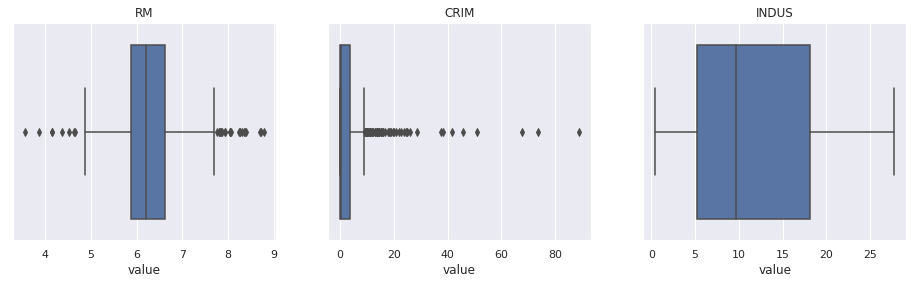

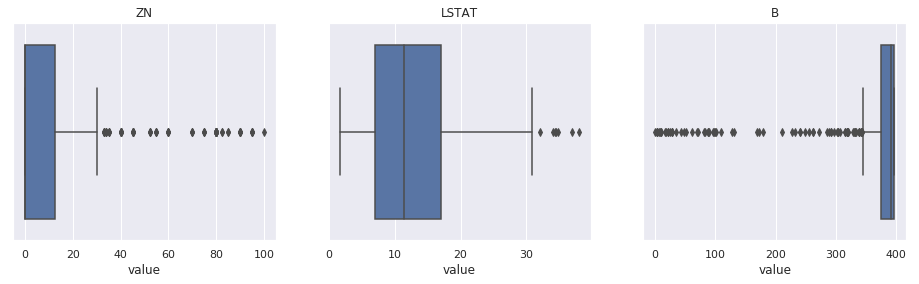

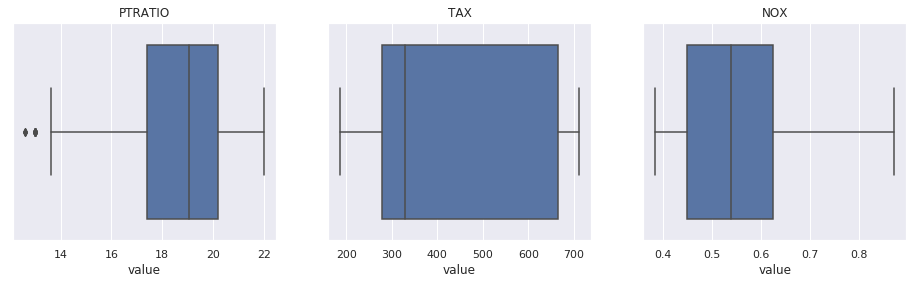

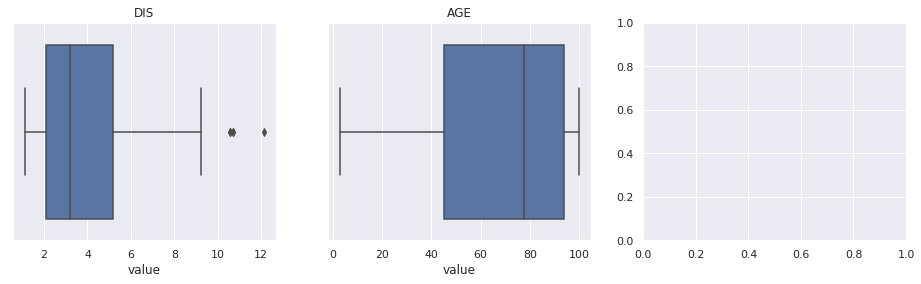

In [92]:
draw_plots(df,num_cols,'value','',3,'boxplot')

We see some outliers which should be threated 

## Countplots for categorical features

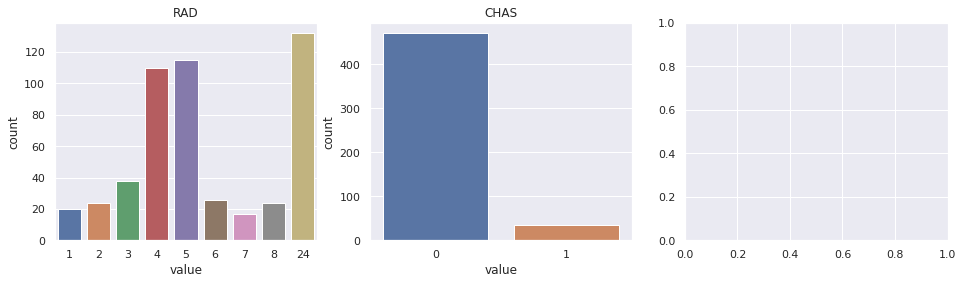

In [93]:
draw_plots(df,cat_cols,'value','count',3,'countplot')

CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise).
Majority of apartments does not tract rivers 

# Train / test split

In [94]:
X = df.copy()
y = df['MEDV'].copy()
X.drop(['MEDV'],axis=1,inplace=True) # Exclude target variable from X dataframe

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
X_train.shape,X_test.shape

((404, 13), (102, 13))

# Baseline on raw data

In [95]:
reg = LinearRegression().fit(X_train, y_train)

In [96]:
reg.score(X_train,y_train) # Score on training data

0.75087587918861454

In [97]:
reg.score(X_test,y_test) # Score on test data

0.66876131104139913

# Data cleaning

## Outliers

In [98]:
df['PTRATIO'] = df[df['PTRATIO'] > df['PTRATIO'].quantile(.025)]['PTRATIO']
df['B'] = df[df['B'] > df['B'].quantile(.025)]['B']

df['LSTAT'] = df[df['LSTAT'] < df['LSTAT'].quantile(.975)]['LSTAT']
df['DIS'] = df[df['DIS'] < df['DIS'].quantile(.975)]['DIS']
df['CRIM'] = df[df['CRIM'] < df['CRIM'].quantile(.975)]['CRIM']
df['ZN'] = df[df['ZN'] < df['ZN'].quantile(.975)]['ZN']

df['RM'] = df[(df['RM'] > df['RM'].quantile(.01))&(df['RM'] < df['RM'].quantile(.99))]['RM']

In [99]:
df.dropna(inplace=True)
df.shape

(424, 14)

# Modeling with cleaned data

## Train / test split

In [100]:
X = df.copy()
y = df['MEDV'].copy()
X.drop(['MEDV'],axis=1,inplace=True) # Exclude target variable from X dataframe

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
X_train.shape,X_test.shape

((339, 13), (85, 13))

In [101]:
reg = LinearRegression().fit(X_train, y_train)

In [102]:
reg.score(X_train,y_train) # Score on training data

0.6823545660178939

In [103]:
reg.score(X_test,y_test) # Score on test data

0.84487315340836644

Score on test data was improved

# Scaling numeric columns

In [104]:
# data before scaling
df.describe()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,TAX,PTRATIO,B,LSTAT,MEDV
count,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000,424.000000
mean,2.270294,7.886719,11.335938,0.551758,6.264140,68.625000,3.713326,398.195755,18.578125,366.665497,12.285048,22.288915
std,4.087355,17.625000,6.667969,0.113464,0.555912,27.468750,1.789123,162.672892,1.953125,71.135315,6.153078,8.008264
min,0.006320,0.000000,0.459961,0.388916,4.903000,2.900391,1.129600,188.000000,14.398438,24.650000,1.730000,7.000000
25%,0.084320,0.000000,5.859375,0.458008,5.897250,46.593750,2.209750,279.750000,17.406250,376.745003,7.385000,17.500000
50%,0.222000,0.000000,9.687500,0.528076,6.201500,76.500000,3.361800,320.000000,19.000000,392.044998,11.490000,21.200000
75%,2.371107,0.000000,18.093750,0.608887,6.545250,93.812500,4.967100,437.000000,20.203125,396.352493,16.245000,24.600000
max,23.648199,80.000000,27.734375,0.871094,8.266000,100.000000,8.344000,711.000000,21.203125,396.899994,29.930000,50.000000


In [105]:
for col in num_cols:
    ss = StandardScaler()
    df[col] = ss.fit_transform(df[col].values.reshape(-1,1))

In [106]:
# data after scaling
df.describe()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,TAX,PTRATIO,B,LSTAT,MEDV
count,4.240000e+02,424.0,424.000000,424.000000,4.240000e+02,424.0,4.240000e+02,4.240000e+02,424.000000,4.240000e+02,4.240000e+02,424.000000
mean,1.799386e-08,0.0,0.000264,0.000417,-4.768372e-07,0.0,-5.398157e-08,6.703233e-17,-0.001317,-1.034647e-07,2.249232e-08,22.288915
std,1.001181e+00,0.0,1.000977,1.000977,1.001181e+00,0.0,1.001181e+00,1.001181e+00,1.000977,1.001181e+00,1.001181e+00,8.008264
min,-5.545515e-01,0.0,-1.633789,-1.438477,-2.451372e+00,-0.0,-1.445836e+00,-1.293664e+00,-2.146484,-4.813636e+00,-1.717436e+00,7.000000
25%,-5.354457e-01,-0.0,-0.823242,-0.828613,-6.607574e-01,-0.0,-8.413915e-01,-7.289824e-01,-0.604004,1.418622e-01,-7.972979e-01,17.500000
50%,-5.017215e-01,0.0,-0.248169,-0.210083,-1.128114e-01,-0.0,-1.967119e-01,-4.812611e-01,0.212769,3.571992e-01,-1.293639e-01,21.200000
75%,2.469381e-02,-0.0,1.014648,0.502930,5.062720e-01,0.0,7.016035e-01,2.388234e-01,0.829590,4.178243e-01,6.443330e-01,24.600000
max,5.236433e+00,0.0,2.460938,2.816406,3.605292e+00,-0.0,2.591294e+00,1.925175e+00,1.342773,4.255300e-01,2.871051e+00,50.000000


In [107]:
X = df.copy()
y = df['MEDV'].copy()
X.drop(['MEDV'],axis=1,inplace=True) # Exclude target variable from X dataframe

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
X_train.shape,X_test.shape

((339, 13), (85, 13))

In [108]:
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_train,y_train) # Score on training data

0.68105834020121037

In [109]:
reg.score(X_test,y_test) # Score on test data

0.84636086154629575

Score on test data was improved